# City Name Generator

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
GPU = True
device = torch.device('cuda' if (torch.cuda.is_available() and GPU) else 'cpu')

This project is inspired by Andrej Karpathy’s makemore series, which teaches how to build neural networks from scratch in a really hands-on way. I’m doing this as part of my learning process to better understand how neural networks and natural language processing (NLP) work.

<br>

The main idea is to train a neural network that can generate new city names that sound like real U.S. cities. It won’t be copying existing names, but instead learning patterns from them, like common letter combinations and name structures, to come up with completely new (and hopefully realistic-sounding) ones.

<br>

For the data, I’m using a U.S. cities dataset from SimpleMaps.com. It includes a bunch of information like the city name, state, and county, but for this project I’m only using the city names. That’s all the model needs to learn how cities are usually named in the U.S.

<br>

This project is mostly for practice and experimenting.



This project also includes ideas and techniques from a few well-known research papers:

- Bengio et al. (2003) – for using embeddings to represent characters in a more meaningful way.<br>

- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift – for adding a BatchNorm layer to help stabilize variance and speed up training.<br>

- Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification – for using Kaiming (He) initialization to improve weight initialization.<br>

- WaveNet: A Generative Model for Raw Audio – for the WaveNet architecture.<br>

## Creating Dataset

To train our neural network, we first need to extract just the city names from the dataset. Then, using a parameter called block_size, we’ll turn these names into training examples for the model.

For example, using the city name Boston" and a block_size of 3, we generate input-output pairs like this:

$$\text{^^^ -> b}$$
$$\text{^^b -> o}$$
$$\text{^bo -> s}$$
$$\text{bos -> t}$$
$$\text{ost -> o}$$
$$\text{sto -> n}$$
$$\text{ton -> ^}$$

where . is a special character indicating either beggining or ending of the name.

<br>

Once all the training examples are created, we split the dataset into:

80% for training

10% for validation (dev)

10% for testing

<br>

Note: All the letters will be made lowercase - this will reduce our vocabulary size

In [2]:
cities = pd.read_csv('uscities.csv')['city'].to_list()
cities = list(set(cities)) # removing duplicates
cities = [city.lower() for city in cities]
chars = sorted(list(set(''.join(cities))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['^'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

### Example of input/output pairs

In [3]:
X = []
Y = []
block_size = 3
for city in cities[:2]:
    context = [0] * block_size
    for char in city + '^':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        print(*[itos[ix] for ix in context], end = '    ')
        print(f'--->    {char}')
        context = context[1:] + [ix]
cities[:2]
random.shuffle(cities)

^ ^ ^    --->    f
^ ^ f    --->    a
^ f a    --->    i
f a i    --->    r
a i r    --->    v
i r v    --->    i
r v i    --->    e
v i e    --->    w
i e w    --->    -
e w -    --->    f
w - f    --->    e
- f e    --->    r
f e r    --->    n
e r n    --->    d
r n d    --->    a
n d a    --->    l
d a l    --->    e
a l e    --->    ^
^ ^ ^    --->    c
^ ^ c    --->    o
^ c o    --->    n
c o n    --->    n
o n n    --->    e
n n e    --->    l
n e l    --->    s
e l s    --->    v
l s v    --->    i
s v i    --->    l
v i l    --->    l
i l l    --->    e
l l e    --->    ^


## Making input/output pairs and splits

In [4]:
block_size = 8

def data_split(cities):  
    X = []
    Y = []
    for city in cities:
        context = [0] * block_size
        for char in city + '^':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'Shape of the input data {X.shape}')
    print(f'Shape of the output data {Y.shape}')
    return X, Y

n1 = int(0.8 * len(cities))
n2 = int(0.9 * len(cities))

X_tr, Y_tr = data_split(cities[:n1])
X_dev, Y_dev = data_split(cities[n1:n2])
X_te, Y_te = data_split(cities[n2:])

Shape of the input data torch.Size([178675, 8])
Shape of the output data torch.Size([178675])
Shape of the input data torch.Size([22365, 8])
Shape of the output data torch.Size([22365])
Shape of the input data torch.Size([22475, 8])
Shape of the output data torch.Size([22475])


## Modules
First let's create from scracth necessary modules (pytorch-like) that are going to be needed for this project.

In [5]:
class Linear():
    def __init__(self, fan_in, fan_out, bias=True, gain=1):
        '''
        Initializes a linear (fully connected) layer.
        
        Args:
            fan_in (int) - number of input features
            fan_out (int) - number of output featurse
            bias (bool) - if True will include bias term, otherwise will not
            gain (float) - gain of the Kaiming (He) initialization (for ReLu is sqrt(2), for Tanh 5/3)
        '''
        self.weight = torch.randn((fan_in, fan_out), device=device) * gain / (fan_in**0.5)
        self.bias  = torch.zeros(fan_out, device=device) if bias else None
        
    def __call__(self, x):
        '''
        Performs a forward pass through the Linear layer : y = x @ W (+ b)
        
        Args:
            x (tensor) - input shape is (batch_size, fan_in)
            
        Output:
            self.out (tensor) - output shape is (batch_size, fan_out)
        '''
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        '''
        Returns a list of all the learnable parameters of the Linear Layer
        '''
        return [self.weight] + ([] if self.bias is None else [self.bias])

    
class Tanh():
    '''
    Tanh non-linearity layer.
    '''
    def __call__(self, x):
        '''
        Performs a forward pass through the tanh non-linearity layer : y = tanh(x)
        
        Args:
            x (tensor) - input shape is (batch_size, fan_in)
            
        Output:
            self.out (tensor) - output shape is (batch_size, fan_in)
        '''
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        '''
        Returns an empty list since Tanh has no learnable parameters.
        '''
        return []
    
    
class Embedding():
    """
    Embedding layer for mapping discrete character indices to dense vectors.
    """
    def __init__(self, vocab_size, emb_dim):
        '''
        Initializes the embedding matrix.
        
        Args:
            vocab_size (int) - number of characters in the vocabulary
            emb_dim (int) - dimension of the embedding vectors
        '''
        self.embedding_table = torch.randn((vocab_size, emb_dim), device=device)
        
    def __call__(self, x):
        '''
        Performs a forward pass through the Embedding layer, i.e. it is embedding characters into emb_dim dimensional vector.
        
        Args:
            x (tensor) - input shape is (batch_size, fan_in)
            
        Output:
            self.out (tensor) - output shape is (batch_size, fan_in, emb_dim)
        '''
        self.out = self.embedding_table[x]
        return self.out
    
    def parameters(self):
        '''
        Returns a list of all the learnable parameters of the Embedding Layer - only the Embedding matrix
        '''
        return [self.embedding_table]

    
class Flatten():
    '''
    Flatten layer reshapes the input tensor by concatenating groups of characters along the feature dimension.
    '''
    def __init__(self, n):
        '''
        Initializes the Flatten layer.
        
        Args:
            n (int) - number of characters that are going to be concatenated
        '''
        self.n = n
    
    def __call__(self, x):
        '''
        Concatenates desired number of characters. If the time (T) dimension becomes 1 it is squeezed out.
        
        Args:
            x (tensor) - input shape is (B, T, C)
        Output:
            self.out (tensor) - input shape is (B, T//n, C*n) if T//n is 1, the the output shape is (B, C*n)
        '''
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        '''
        Returns an empty list since Flatten has no learnable parameters.
        '''
        return []

    
class Sequential():
    '''
    A Container class that is going to store all our layers.
    '''
    def __init__(self, layers):
        '''
        Initializes Sequential with all the layers in our network
        
        Args:
            layers (list): List of layer objects to apply in sequence.
        '''
        self.layers = layers
    
    def __call__(self, x):
        '''
        Does a forward pass through all the layers inside this container
        
        Args:
            x (Tensor): Input tensor

        Output:
            Tensor: Output tensor after applying all layers
        '''
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        '''
        Returns all the learnable parameters of the layers that are soted inside
        '''
        return [p for layer in self.layers for p in layer.parameters()]
    
    def to(self, device):
        for p in self.parameters():
            p.data = p.data.to(device)
    
    
    
class BatchNorm():
    """
    BatchNorm layer that normalizes inputs to stabilize and accelerate training.
    Supports both 2D and 3D tensors.
    """
    def __init__(self, dim, momentum = 0.1, eps = 1e-8):
        '''
        Initializes BatchNorm layer.
        
        Args:
            dim (int): Number of features (usually the size of the last dimension).
            momentum (float) - used to calculate running mean and variance
            eps (float) - small positive number that helps to avoid division by zero when narmalizing by standard deviation
        
        Atributes:
            training (bool) - indicates wheter the model is in training state or in eval state
            gamma (float) - BatchNorm layer parameter used to scale the normalized inputs
            beta (float) - BatchNorm layer parameter used to shift the normalized inputs
            running_mean (float) - stores calculated mean 
            running_var (float) - stores calculated var
        '''
        self.momentum = momentum
        self.eps = eps
        self.training = True
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)
    
    def __call__(self, x):
        """
        Applies batch normalization to input tensor as defined in the paper.

        Args:
            x (Tensor): Input tensor of shape (B, C) or (B, T, C)

        Returns:
            self.out (tensor): Normalized and scaled input
        """
        if self.training:
            if x.ndim == 3:
                dim = (0, 1)         
            elif x.ndim == 2:
                dim = 0   
            x_mean = x.mean(dim=dim, keepdim=True)
            x_var = x.var(dim=dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*x_mean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*x_var
        
        self.out = self.gamma * ((x-x_mean)/torch.sqrt(x_var+self.eps)) + self.beta
        return self.out
        
    def parameters(self):
        '''
        Return all the learnable parameters of the BatchNOrm layer
        '''
        return [self.gamma, self.beta]

In [6]:
def eval_split(split, model):
    for layer in model.layers:
        if isinstance(layer, BatchNorm):
            layer.training = False
    x, y = {'train': (X_tr, Y_tr),
            'dev'  : (X_dev, Y_dev),
            'test' : (X_te, Y_te)}[split]
    x, y = x.to(device), y.to(device)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    for layer in model.layers:
        if isinstance(layer, BatchNorm):
            layer.training = True

In [7]:
def find_learning_rate(lre, batch_size, model):
    lrs = 10**lre
    losses = []

    for lr in lrs:

        ix = torch.randint(high=X_tr.shape[0], size=(batch_size,))
        Xb, Yb = X_tr[ix], Y_tr[ix]

        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        losses.append(loss.log10().item())

        for p in model.parameters():
            p.grad = None

        loss.backward()
        for p in model.parameters():
            p.data -= lr*p.grad
    plt.figure()
    plt.plot(lre,losses)
    plt.xlabel('log10(learning_rate)')
    plt.ylabel('loss')

In [8]:
def train_model(model, bath_size, lr, max_steps):
    losses = []
    
    for i in range(max_steps):
        ix = torch.randint(high=X_tr.shape[0], size=(batch_size,))
        Xb, Yb = X_tr[ix].to(device), Y_tr[ix].to(device)

        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        loss_val = loss.item()
        losses.append(math.log10(loss_val))

        for p in model.parameters():
            p.grad = None
        
        if i == int(0.7*max_steps):
            lr /= 10
        
        loss.backward()
        for p in model.parameters():
            p.data -= lr*p.grad
            
        if i % 10000 == 0:
             print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
          
    return losses

In [9]:
def plot_loss(loss):
    plt.plot(torch.tensor(loss).view(-1, 1000).mean(1))

In [28]:
emb_dim = 10
n_hidden = 20
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, vocab_size, gain=0.1)
])

model1.to(device)
    
for p in model1.parameters():
    p.requires_grad = True
           

## Making Model

Model will follow WaveNet architecute, concatenating 2 by 2 characters until we concatenate all block_size characters into a single sequence

In [10]:
emb_dim = 5
n_hidden = 50
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.01)
])

model1.to(device)

for p in model1.parameters():
      p.requires_grad = True

#### Finding Learning rate

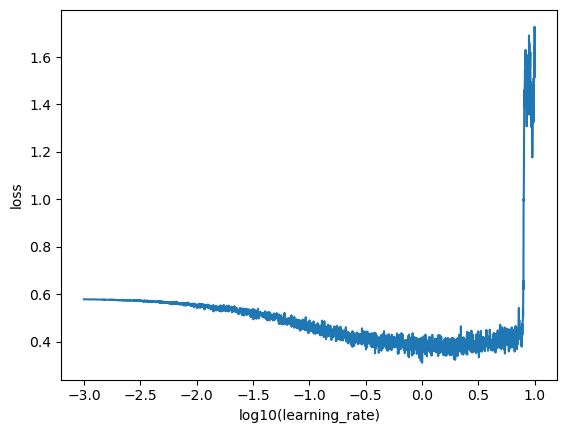

In [228]:
lre = torch.linspace(-3, 1, 3000)
batch_size = 128
find_learning_rate(lre, batch_size, model1)

It seems like the good starting learning rate would be $1$

#### Training first model

In [11]:
lr = 10**0
batch_size = 128
max_steps = 200000
import time
start = time.time()
l = train_model(model1, batch_size, lr, max_steps)
end = time.time()
print(f"Time elapsed: {end - start:.2f} seconds")

      0/ 200000: 3.7850
  10000/ 200000: 2.0265
  20000/ 200000: 2.0305
  30000/ 200000: 1.9167
  40000/ 200000: 1.8387
  50000/ 200000: 1.8984
  60000/ 200000: 1.9182
  70000/ 200000: 2.0043
  80000/ 200000: 1.7442
  90000/ 200000: 1.8951
 100000/ 200000: 1.9568
 110000/ 200000: 1.8771
 120000/ 200000: 1.8042
 130000/ 200000: 2.0383
 140000/ 200000: 1.8649
 150000/ 200000: 2.0194
 160000/ 200000: 2.0160
 170000/ 200000: 1.8065
 180000/ 200000: 1.9390
 190000/ 200000: 1.7148
Time elapsed: 2418.55 seconds


In [232]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.7717525959014893
dev 1.8788166046142578
test 1.8939129114151


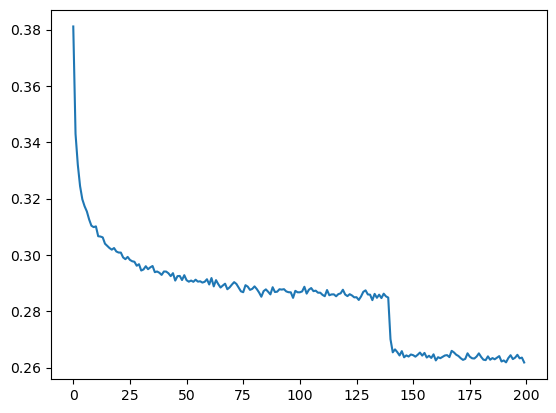

In [214]:
plot_loss(l)

#### Second model

Let's try and increase embedding dimension

In [233]:
emb_dim = 10
n_hidden = 50
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True

In [234]:
lr = 10**0
bath_size = 128
max_steps = 200000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 200000: 3.7835
  10000/ 200000: 1.9314
  20000/ 200000: 1.9528
  30000/ 200000: 1.8970
  40000/ 200000: 1.8809
  50000/ 200000: 1.8742
  60000/ 200000: 1.6860
  70000/ 200000: 2.0275
  80000/ 200000: 1.7873
  90000/ 200000: 1.7507
 100000/ 200000: 1.7964
 110000/ 200000: 1.7945
 120000/ 200000: 1.8538
 130000/ 200000: 1.9863
 140000/ 200000: 1.8186
 150000/ 200000: 1.6959
 160000/ 200000: 1.4761
 170000/ 200000: 1.7962
 180000/ 200000: 1.8741
 190000/ 200000: 1.7319


In [235]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.7525131702423096
dev 1.8703575134277344


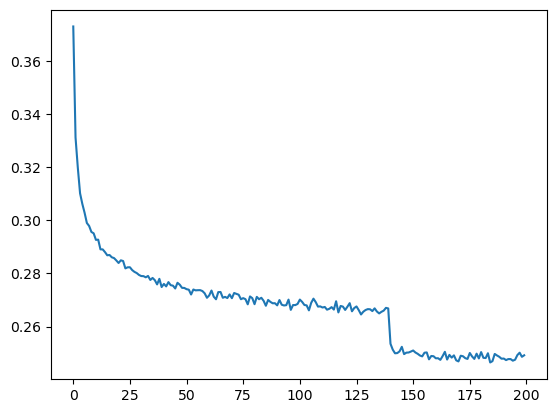

In [236]:
plot_loss(l)

We did lower our loss, but not by much, let's try to lift the emb dim to 15 and see if we should instead focus on the number of hidden layers.

#### Third Model

In [237]:
emb_dim = 15
n_hidden = 50
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True
        
lr = 10**0
bath_size = 128
max_steps = 200000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 200000: 3.7841
  10000/ 200000: 1.8153
  20000/ 200000: 1.7279
  30000/ 200000: 1.9285
  40000/ 200000: 1.8770
  50000/ 200000: 1.7595
  60000/ 200000: 2.0218
  70000/ 200000: 1.8361
  80000/ 200000: 1.9725
  90000/ 200000: 1.8289
 100000/ 200000: 1.9955
 110000/ 200000: 1.8315
 120000/ 200000: 1.8791
 130000/ 200000: 1.5705
 140000/ 200000: 1.9578
 150000/ 200000: 1.7698
 160000/ 200000: 1.8087
 170000/ 200000: 1.5716
 180000/ 200000: 2.0347
 190000/ 200000: 1.8499


In [238]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.7297847270965576
dev 1.8700472116470337


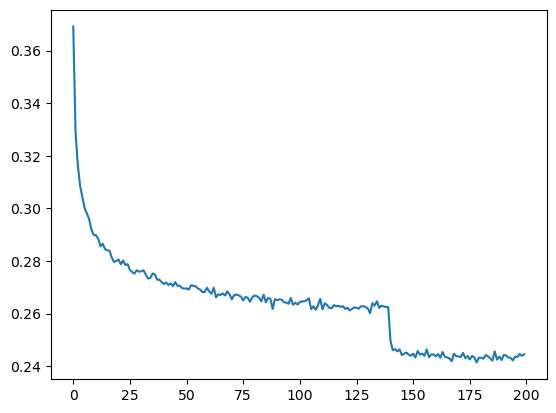

In [239]:
plot_loss(l)

It seems that the bottleneck is the number of nodes in the hidden layer let's try to increase it.

#### Fourth Model

In [240]:
emb_dim = 10
n_hidden = 100
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True
        
lr = 10**0
bath_size = 128
max_steps = 200000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 200000: 3.7842
  10000/ 200000: 2.0595
  20000/ 200000: 1.7127
  30000/ 200000: 1.7434
  40000/ 200000: 2.0550
  50000/ 200000: 1.8222
  60000/ 200000: 1.6862
  70000/ 200000: 1.6508
  80000/ 200000: 1.6719
  90000/ 200000: 1.9118
 100000/ 200000: 1.6162
 110000/ 200000: 1.6416
 120000/ 200000: 1.5533
 130000/ 200000: 1.5843
 140000/ 200000: 1.5762
 150000/ 200000: 1.5145
 160000/ 200000: 1.5889
 170000/ 200000: 1.5497
 180000/ 200000: 1.5303
 190000/ 200000: 1.4717


In [241]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.4773229360580444
dev 1.875963568687439


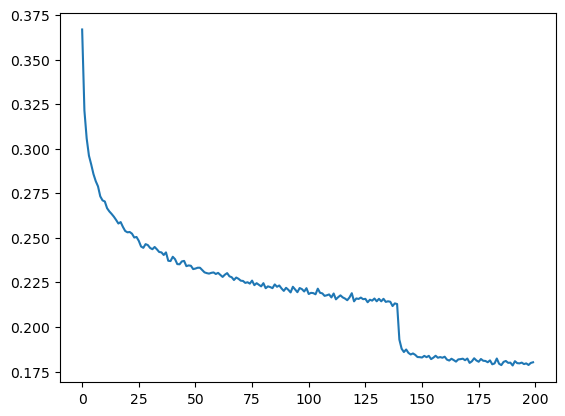

In [242]:
plot_loss(l)

In [243]:
emb_dim = 15
n_hidden = 100
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True
        
lr = 10**0
bath_size = 128
max_steps = 200000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 200000: 3.7846
  10000/ 200000: 1.8487
  20000/ 200000: 1.6594
  30000/ 200000: 1.7456
  40000/ 200000: 1.7218
  50000/ 200000: 1.5578
  60000/ 200000: 1.5810
  70000/ 200000: 1.6060
  80000/ 200000: 1.8336
  90000/ 200000: 1.8271
 100000/ 200000: 1.5578
 110000/ 200000: 1.4909
 120000/ 200000: 1.8326
 130000/ 200000: 1.4755
 140000/ 200000: 1.4431
 150000/ 200000: 1.5523
 160000/ 200000: 1.4870
 170000/ 200000: 1.3370
 180000/ 200000: 1.7257
 190000/ 200000: 1.6493


In [244]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.4621248245239258
dev 1.8774704933166504


In [245]:
emb_dim = 10
n_hidden = 30
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True

In [247]:
lr = 10**0
bath_size = 128
max_steps = 200000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 200000: 3.7835
  10000/ 200000: 2.1505
  20000/ 200000: 1.9677
  30000/ 200000: 2.0095
  40000/ 200000: 1.7002
  50000/ 200000: 1.8601
  60000/ 200000: 1.8632
  70000/ 200000: 1.9258
  80000/ 200000: 1.9844
  90000/ 200000: 2.2682
 100000/ 200000: 1.8704
 110000/ 200000: 1.8450
 120000/ 200000: 1.8061
 130000/ 200000: 1.8143
 140000/ 200000: 1.7772
 150000/ 200000: 1.7805
 160000/ 200000: 1.7396
 170000/ 200000: 1.7366
 180000/ 200000: 1.7968
 190000/ 200000: 1.8754


In [248]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.7068102359771729
dev 1.8645890951156616


In [249]:
emb_dim = 10
n_hidden = 30
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Linear(2*n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True

In [250]:
lr = 10**0
bath_size = 128
max_steps = 200000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 200000: 3.7849
  10000/ 200000: 1.9059
  20000/ 200000: 1.6833
  30000/ 200000: 1.9867
  40000/ 200000: 1.8650
  50000/ 200000: 1.6940
  60000/ 200000: 1.8415
  70000/ 200000: 1.6931
  80000/ 200000: 1.5767
  90000/ 200000: 1.6996
 100000/ 200000: 1.6100
 110000/ 200000: 1.8408
 120000/ 200000: 1.7536
 130000/ 200000: 1.7735
 140000/ 200000: 1.7191
 150000/ 200000: 1.6029
 160000/ 200000: 1.5985
 170000/ 200000: 1.6093
 180000/ 200000: 1.5021
 190000/ 200000: 1.5695


In [251]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.5817148685455322
dev 1.8600505590438843


In [259]:
emb_dim = 10
n_hidden = 30
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.01)
])

for p in model1.parameters():
      p.requires_grad = True

In [260]:
lr = 10**0
bath_size = 128
max_steps = 170000
l = train_model(model1, bath_size, lr, max_steps)

      0/ 170000: 3.7833
  10000/ 170000: 1.9464
  20000/ 170000: 1.9312
  30000/ 170000: 2.0062
  40000/ 170000: 2.0421
  50000/ 170000: 2.0634
  60000/ 170000: 2.1748
  70000/ 170000: 2.0407
  80000/ 170000: 1.8188
  90000/ 170000: 2.1499
 100000/ 170000: 2.0404
 110000/ 170000: 1.9121
 120000/ 170000: 1.9333
 130000/ 170000: 2.0099
 140000/ 170000: 1.9154
 150000/ 170000: 1.7604
 160000/ 170000: 1.7610


In [261]:
eval_split('train', model1)
eval_split('dev', model1)

train 1.8690942525863647
dev 1.9205697774887085
